In [175]:
import torch
import librosa
from VQVAE_speech import data_preprocessing
import os
from torch.utils.data import DataLoader
import torchaudio
import numpy as np
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [176]:
model = torch.load('models/model.pt')
model.load_state_dict(torch.load('models/model_st.pt'))

<All keys matched successfully>

In [178]:
fs = 16e3
dataset_path = os.path.join(os.getcwd(), "data")
batch_size = 1

In [177]:
def sound_from_sample(data, fs, filename):
    fs = int(fs)
    S = librosa.feature.inverse.mel_to_stft(data, n_fft=int(fs * 0.025), power=1.0)
    y = librosa.griffinlim(S)
    scaled = np.int16(y / np.max(np.abs(y)) * 32767).T
    write(filename, fs, scaled)

In [179]:
test_data = torchaudio.datasets.LIBRISPEECH(dataset_path, url='test-clean', download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True,
                         collate_fn=lambda x: data_preprocessing(x[0], fs))

In [180]:
model.eval()

(originals, _) = next(iter(test_loader))
originals_db = librosa.power_to_db(originals, ref=np.max)
originals = originals.to(device)

_, reconstructions, _ = model(originals)
reconstructions_db = librosa.power_to_db(reconstructions.detach().cpu(), ref=np.max)

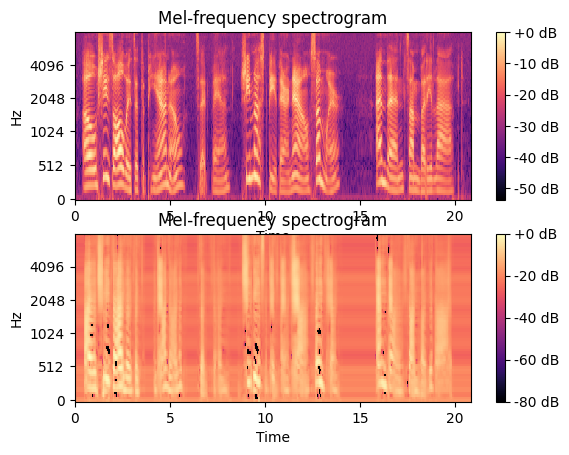

In [181]:
fig, axes = plt.subplots(2)

img = librosa.display.specshow(originals_db.squeeze(), x_axis='time',
                               y_axis='mel', sr=fs,
                               fmax=8000, ax=axes[0])

fig.colorbar(img, ax=axes[0], format='%+2.0f dB')
axes[0].set(title='Mel-frequency spectrogram')

img2 = librosa.display.specshow(reconstructions_db.squeeze(), x_axis='time',
                               y_axis='mel', sr=fs,
                               fmax=8000, ax=axes[1])

fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')
axes[1].set(title='Mel-frequency spectrogram')


plt.show()


In [182]:
sound_from_sample(originals.cpu().numpy(), fs, 'test.wav')
sound_from_sample(reconstructions.cpu().detach().numpy(), fs, 'recon.wav')
